In [1]:
import pandas as pd
import numpy as np 
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import pickle  # Save and load model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\msouh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
analyzer=SentimentIntensityAnalyzer()
vaderLex=analyzer.lexicon
print(vaderLex.get("love"))#Does not detect with CAPITAL letters

3.2


In [4]:
print(analyzer.polarity_scores("love you so much , see you bye , i hate you"))

{'neg': 0.248, 'neu': 0.47, 'pos': 0.282, 'compound': 0.128}


In [5]:
training_set=pd.read_csv("train.csv")

In [6]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   desc_id           1985 non-null   int64 
 1   source_name       1985 non-null   object
 2   review_text       1984 non-null   object
 3   is_accessibility  1985 non-null   object
 4   cleanText         1982 non-null   object
 5   Vader Sentiment   1985 non-null   object
dtypes: int64(1), object(5)
memory usage: 93.2+ KB


### No nan Values

In [7]:
training_set.head()

,desc_id,source_name,review_text,is_accessibility,cleanText,Vader Sentiment
0,1,gp_AOqpTOE-4PtpSwSKzv8CF6EtR6seFSLwg-QQPTpQKze...,Excellent app. Been using it for years on man...,Accessibility Review,excellent app using years many different phone...,Positive
1,1,gp_AOqpTOGPKJI_1QuwFgSTcvd7BanaHdhJoLUXZDx8OVt...,I've used this on a different phone - but cur...,Accessibility Review,used different phone currently moto android re...,Positive
2,1,lg_AOqpTOE5_m1p9SEdAbCNs_Nh_qN7EHMLnyPnytEW9NX...,Fantastic program! Instant search results and...,Accessibility Review,fantastic program instant search results fast ...,Positive
3,1,lg_AOqpTOEyZAX-Z1qAqVvbqV8s6vJAttZvFBFixQTM_jW...,I'm using this on my mobile as well as on PC ...,Accessibility Review,using mobile well view offline dictionaries us...,Positive
4,1,gp_AOqpTOE6SfnT_RCAb9w8AbMpASAbJDvsJIHxp_xuhKg...,Text reflow doesn't work. I want my money back...,Accessibility Review,text reflow work want money back,Positive


In [8]:
training_set[training_set['Vader Sentiment']=="Neutral"].count()

desc_id             181
source_name         181
review_text         180
is_accessibility    181
cleanText           178
Vader Sentiment     181
dtype: int64

In [9]:
training_set = training_set.drop(index=training_set[training_set['Vader Sentiment'] == "Neutral"].index)#Dropping neutral sentiment


In [10]:
training_set[training_set['Vader Sentiment']=="Neutral"].count()

desc_id             0
source_name         0
review_text         0
is_accessibility    0
cleanText           0
Vader Sentiment     0
dtype: int64

In [11]:
training_set.head(1)

,desc_id,source_name,review_text,is_accessibility,cleanText,Vader Sentiment
0,1,gp_AOqpTOE-4PtpSwSKzv8CF6EtR6seFSLwg-QQPTpQKze...,Excellent app. Been using it for years on man...,Accessibility Review,excellent app using years many different phone...,Positive


In [12]:
def compute_score(text):
    scores = []
    if isinstance(text, str):  
        for word in text.split():  
            score = vaderLex.get(word, 0)
            scores.append(score)  
    return scores  

In [13]:
training_set['Numerical Features'] = training_set['cleanText'].apply(compute_score)#Applying the func for each row


In [14]:
training_set.tail(3)

,desc_id,source_name,review_text,is_accessibility,cleanText,Vader Sentiment,Numerical Features
1981,1,gp_AOqpTOGLFnORYm9M6DkAuG6-VJzlIUV0T4jPmGB7-gj...,it is realy nice - I loved it . it is top ca...,Accessibility Review,realy nice loved top candidate reader favorite...,Positive,"[0, 1.8, 2.9, 0.8, 0, 0, 2.0, 0, 0, 0, 0, 0, 0..."
1983,1,gp_AOqpTOGpOhiVI2WL_uwhHuu_ZhwYnTXwJLDPt-4-9_Z...,Slick layout and design and very functional b...,Accessibility Review,slick layout design functional sometimes throw...,Positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0..."
1984,1,gp_AOqpTOGpwNMVoUce48nQ7_cVsgQ7bnZ3LB0bjnJ3qmF...,I loved the app and all features including th...,Accessibility Review,loved app features including flexibility layou...,Positive,"[2.9, 0, 0, 0, 1.4, 0, 1.5, 0, 0, 0, 0, 0, 0, ..."


In [15]:
max_length = max(training_set['Numerical Features'].apply(len))


In [16]:
def pad_sequence(scores):
    return scores + [0] * (max_length - len(scores))

In [17]:
training_set['Conc_Features'] = training_set['Numerical Features'].apply(pad_sequence)

In [18]:
X = np.array(training_set['Conc_Features'].values.tolist())
y = (training_set["Vader Sentiment"]=="Positive").astype(int).values

In [19]:
def initialize_weights(n_features):  
    bias = 0
    weights = np.zeros(n_features)
    return weights, bias

def sigm_func(z):
    return 1 / (1 + np.exp(-z))

def loss_func(y_true, y_pred):
    m = len(y_true)
    loss = -(1/m) * np.sum(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9))  
    return loss

In [20]:
def gradient_descent(X, y, weights, bias, learning_rate, epochs):
    m = X.shape[0]  
    losses = []  
    accuracies = []  
    
    #Forward Pass
    for epoch in range(epochs):
        linear_model = np.dot(X, weights) + bias  # Linear combination
        y_pred = sigm_func(linear_model)  # Apply sigmoid 
        
        #Backward Pass
        dw = (1/m) * np.dot(X.T, (y_pred - y))  # Gradient of weights
        db = (1/m) * np.sum(y_pred - y)  # Gradient of bias

        # Update Weight and Bias
        weights -= learning_rate * dw  
        bias -= learning_rate * db  

        if epoch % 20 == 0:
            loss = loss_func(y, y_pred)
            losses.append(loss)

            y_pred_binary = (y_pred >= 0.5).astype(int)
            accuracy = accuracy_score(y, y_pred_binary)
            accuracies.append(accuracy)

            print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    return weights, bias, losses, accuracies

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)


In [22]:
learning_rate = 0.07
epochs = 500
n_features = X_train.shape[1]

weights, bias = initialize_weights(n_features)
weights, bias, losses, accuracies = gradient_descent(X_train, y_train, weights, bias, learning_rate, epochs)

Epoch 0, Loss: 0.6931, Accuracy: 0.8787
Epoch 20, Loss: 0.3853, Accuracy: 0.9030
Epoch 40, Loss: 0.3052, Accuracy: 0.9051
Epoch 60, Loss: 0.2685, Accuracy: 0.9058
Epoch 80, Loss: 0.2470, Accuracy: 0.9058
Epoch 100, Loss: 0.2326, Accuracy: 0.9078
Epoch 120, Loss: 0.2220, Accuracy: 0.9085
Epoch 140, Loss: 0.2137, Accuracy: 0.9113
Epoch 160, Loss: 0.2068, Accuracy: 0.9141
Epoch 180, Loss: 0.2010, Accuracy: 0.9175
Epoch 200, Loss: 0.1960, Accuracy: 0.9182
Epoch 220, Loss: 0.1915, Accuracy: 0.9203
Epoch 240, Loss: 0.1874, Accuracy: 0.9224
Epoch 260, Loss: 0.1838, Accuracy: 0.9231
Epoch 280, Loss: 0.1804, Accuracy: 0.9252
Epoch 300, Loss: 0.1772, Accuracy: 0.9272
Epoch 320, Loss: 0.1743, Accuracy: 0.9279
Epoch 340, Loss: 0.1715, Accuracy: 0.9300
Epoch 360, Loss: 0.1689, Accuracy: 0.9307
Epoch 380, Loss: 0.1665, Accuracy: 0.9314
Epoch 400, Loss: 0.1642, Accuracy: 0.9328
Epoch 420, Loss: 0.1620, Accuracy: 0.9362
Epoch 440, Loss: 0.1599, Accuracy: 0.9362
Epoch 460, Loss: 0.1579, Accuracy: 0.936

In [23]:
y_val_pred = sigm_func(np.dot(X_val, weights) + bias)  
y_val_pred_binary = (y_val_pred >= 0.5).astype(int)  

final_accuracy = accuracy_score(y_val, y_val_pred_binary)
print(f"\nValidation Accuracy: {final_accuracy}")


Validation Accuracy: 0.9335180055401662


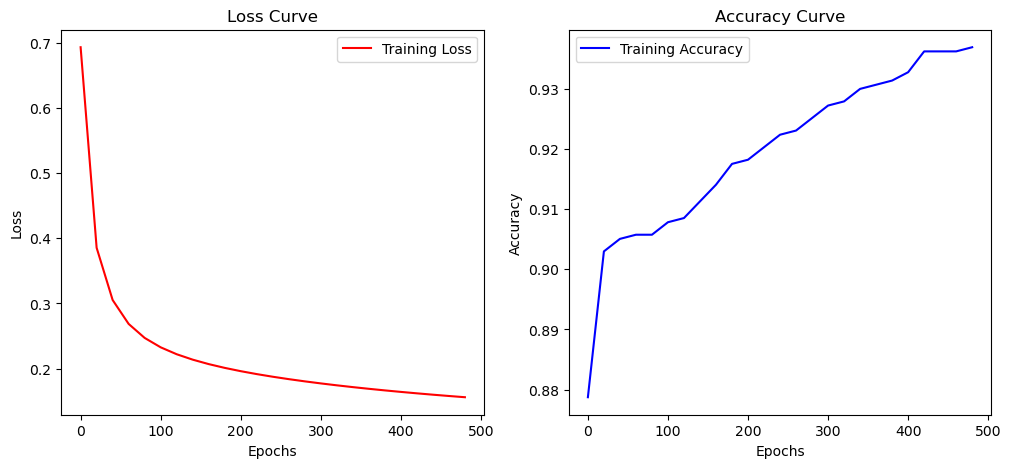

In [25]:
epochs_list = np.arange(0, epochs, 20)  

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, losses, label="Training Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, accuracies, label="Training Accuracy", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


In [ ]:
model_data = {
    "weights": weights,
    "bias": bias
}

with open("model.pkl", "wb") as f:
    pickle.dump(model_data, f)
print("\nModel saved")


Model saved
